#   Plant Disease Prediction using ResNet-18 model

# Description about this project
**This project trains a machine learning model to classify plant diseases based on images of plant leaves. It uses a labeled dataset of plant images, where each image is categorized by disease type. The model is trained to learn patterns in these images that are specific to each disease.**
**Here’s what it does with the input and output:**

**Input (Plant Images): The project uses these labeled images to train the ResNet-18 model to recognize specific features associated with different diseases.**

**Output (Trained Model and Metrics): The trained model can then be used to predict the disease in new, unlabeled plant images. The model’s accuracy, precision, recall, F1-score, and confusion matrix provide insights into its performance, showing how well it distinguishes between different diseases.**

**In essence, the project builds a classifier that can help identify plant diseases from new images, potentially assisting farmers or agricultural experts in diagnosing plant health issues.**

**Steps to execute the program:**
**Method 1**
1. Open this link for the kaggle 'dataset': https://www.kaggle.com/datasets/pawanmugalihalli/plantvillagedataset2
2. It will take you to Kaggle dateset 'plantvillagedataset2'.
3. Click on 'New Notebook', it will create a kaggle notebook.
4. Go to settings -> Go to Accelerator -> Select any one of the GPUs (if available).
5. Copy the python file from vpl and past it here in one cell.
6. Run it.

**Alternate method**

**Link for the kaggle 'notebook' of my project (Made it public):**
https://www.kaggle.com/code/pawanmugalihalli/resnet50-2

1.You can open my kaggle notebook from this link and click on edit.

2.Run each cell.

**Importing all necessary libraries and modules, including PyTorch, torchvision, and other utilities. These libraries support data handling, model training, evaluation, and visualization.**

In [1]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from tqdm import tqdm

**Specifying the directory path where the plant disease dataset is stored. This will be used to load images and labels.**

In [2]:
dir_path = "/kaggle/input/plantvillagedataset2/dataset2"

**This cell loads images and labels from the specified directory, converting each image to an array and storing labels for each class. It checks the dimensions to ensure all images are consistent and stores unique label names.**

In [3]:
data = []
label_names = []
distinct_labels = set()
directory = os.listdir(dir_path)
for subdir in directory:
    subdir_path = os.path.join(dir_path, subdir)
    subdirectory = os.listdir(subdir_path)
    for image in subdirectory:
        img = np.asarray(Image.open(os.path.join(subdir_path, image)))
        if img.shape == (256, 256, 3):
            data.append(img)
            label_names.append(subdir)
            distinct_labels.add(subdir)
data = np.array(data)
label_names = np.array(label_names)
distinct_labels = sorted(distinct_labels)

**Outputs the shapes of the data and label_names arrays to verify that the data loading process was successful and to check the dataset dimensions.**

In [4]:
print(data.shape)
print(label_names.shape)

(18160, 256, 256, 3)
(18160,)


**Converts label_names into numerical labels based on the index of each label in distinct_labels. It then prints the array of numeric labels to verify conversion.**

In [5]:
labels = []
for i in label_names:
    labels.append(distinct_labels.index(i))
labels = np.array(labels).astype(np.int64)
print(labels)

[2 2 2 ... 5 5 5]


**Splits the dataset into training, validation, and test sets. The first split creates training and validation data (80-20 split), and the second split creates validation and test data (further splitting the 20% validation set).**

In [6]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.20)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.10)

**Defines a custom dataset class, PlantVillageDataset, to handle image and label data for PyTorch's DataLoader. It includes optional transformations for data augmentation and returns image-label pairs.**

In [7]:
class PlantVillageDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

**Defines data augmentation transforms for training and validation, initializes DataLoaders for each dataset split, and sets the computation device (CPU or GPU). losses and accs dictionaries will store training and validation performance metrics.**

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(180),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

loaders = {'train': DataLoader(PlantVillageDataset(X_train, y_train, transform=data_transforms['train']), shuffle=True, batch_size=32), \
           'val': DataLoader(PlantVillageDataset(X_val, y_val, transform=data_transforms['val']), shuffle=True, batch_size=32), \
           'test': DataLoader(PlantVillageDataset(X_test, y_test, transform=data_transforms['val']), shuffle=True, batch_size=32)}
dataset_sizes = {'train': len(X_train), 'val': len(X_val), 'test': len(X_test)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
losses = {'train': [], 'val': []}
accs = {'train': [], 'val': []}

**Defines a train function for a training epoch. This function computes predictions, calculates loss, updates weights, and appends metrics to losses and accs.**

In [9]:
def train(model, criterion, optimizer, scheduler):
    model.train()
    total_loss = 0.0
    total_correct = 0

    for inputs, labels in tqdm(loaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.enable_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_correct += torch.sum(preds == labels.data)
    scheduler.step()

    train_loss = total_loss / dataset_sizes['train']
    train_acc = total_correct.cpu() / dataset_sizes['train']
    losses['train'].append(train_loss)
    accs['train'].append(train_acc)
    return train_loss, train_acc

**Defines a val function for the validation phase, computing loss and accuracy for the validation set without updating the model parameters. The function appends the metrics for tracking.**

In [10]:
def val(model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0

    for inputs, labels in loaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        total_correct += torch.sum(preds == labels.data)

    val_loss = total_loss / dataset_sizes['val']
    val_acc = total_correct.cpu() / dataset_sizes['val']
    losses['val'].append(val_loss)
    accs['val'].append(val_acc)
    return val_loss, val_acc

**Computing the test set loss and accuracy, as well as generating a confusion matrix and calculating precision, recall, and F1-score for model evaluation.**

In [11]:
def test(model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    true_labels = []
    pred_labels = []

    for inputs, labels in loaders['test']:
        inputs = inputs.to(device)
        true_labels.extend(labels)
        labels = labels.to(device)

        
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            pred_labels.extend(preds.cpu())
            loss = criterion(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        total_correct += torch.sum(preds == labels.data)

    test_loss = total_loss / dataset_sizes['test']
    test_acc = total_correct / dataset_sizes['test']
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
    return test_loss, test_acc, conf_matrix, precision, recall, f1

**Loads a pre-trained ResNet-18 model with ImageNet weights as a starting point for fine-tuning on plant disease data.**

In [12]:
model = models.resnet18(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


**Modifies the last layer of the ResNet-18 model to match the number of plant disease classes. It also defines the loss function, optimizer, and learning rate scheduler.**

In [13]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(distinct_labels))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

**Runs the training loop for a specified number of epochs, saving the model state when validation accuracy improves. It also tracks and prints the training and validation metrics.**

In [14]:
import os
import torch

num_epochs = 25
best_model_params_path = "resnetcheckpoints/best_model_params2.pt"

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(best_model_params_path), exist_ok=True)

torch.save(model.state_dict(), best_model_params_path)
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    train_loss, train_acc = train(model, criterion, optimizer, scheduler)
    val_loss, val_acc = val(model, criterion)

    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_model_params_path)
    print()

print(f'Best Validation Acc: {best_acc:4f}')

Epoch 1/25
----------


100%|██████████| 454/454 [02:48<00:00,  2.69it/s]


Train Loss: 0.6360 Acc: 0.7840
Validation Loss: 0.3450 Acc: 0.8804

Epoch 2/25
----------


100%|██████████| 454/454 [02:47<00:00,  2.71it/s]


Train Loss: 0.3380 Acc: 0.8871
Validation Loss: 0.4860 Acc: 0.8516

Epoch 3/25
----------


100%|██████████| 454/454 [02:47<00:00,  2.71it/s]


Train Loss: 0.2679 Acc: 0.9092
Validation Loss: 0.1995 Acc: 0.9342

Epoch 4/25
----------


100%|██████████| 454/454 [02:47<00:00,  2.72it/s]


Train Loss: 0.2405 Acc: 0.9160
Validation Loss: 0.4294 Acc: 0.8672

Epoch 5/25
----------


100%|██████████| 454/454 [02:48<00:00,  2.69it/s]


Train Loss: 0.2010 Acc: 0.9316
Validation Loss: 0.1639 Acc: 0.9425

Epoch 6/25
----------


100%|██████████| 454/454 [02:47<00:00,  2.71it/s]


Train Loss: 0.1858 Acc: 0.9370
Validation Loss: 0.2653 Acc: 0.9073

Epoch 7/25
----------


100%|██████████| 454/454 [02:45<00:00,  2.74it/s]


Train Loss: 0.1772 Acc: 0.9416
Validation Loss: 0.1611 Acc: 0.9468

Epoch 8/25
----------


100%|██████████| 454/454 [02:45<00:00,  2.74it/s]


Train Loss: 0.0822 Acc: 0.9732
Validation Loss: 0.0597 Acc: 0.9777

Epoch 9/25
----------


100%|██████████| 454/454 [02:45<00:00,  2.74it/s]


Train Loss: 0.0600 Acc: 0.9800
Validation Loss: 0.0407 Acc: 0.9859

Epoch 10/25
----------


100%|██████████| 454/454 [02:46<00:00,  2.73it/s]


Train Loss: 0.0508 Acc: 0.9824
Validation Loss: 0.0491 Acc: 0.9816

Epoch 11/25
----------


100%|██████████| 454/454 [02:44<00:00,  2.76it/s]


Train Loss: 0.0501 Acc: 0.9838
Validation Loss: 0.0381 Acc: 0.9856

Epoch 12/25
----------


100%|██████████| 454/454 [02:45<00:00,  2.74it/s]


Train Loss: 0.0469 Acc: 0.9846
Validation Loss: 0.0388 Acc: 0.9856

Epoch 13/25
----------


100%|██████████| 454/454 [02:45<00:00,  2.74it/s]


Train Loss: 0.0419 Acc: 0.9864
Validation Loss: 0.0326 Acc: 0.9893

Epoch 14/25
----------


100%|██████████| 454/454 [02:45<00:00,  2.75it/s]


Train Loss: 0.0409 Acc: 0.9849
Validation Loss: 0.0369 Acc: 0.9862

Epoch 15/25
----------


100%|██████████| 454/454 [02:45<00:00,  2.75it/s]


Train Loss: 0.0338 Acc: 0.9888
Validation Loss: 0.0304 Acc: 0.9884

Epoch 16/25
----------


100%|██████████| 454/454 [02:45<00:00,  2.75it/s]


Train Loss: 0.0333 Acc: 0.9884
Validation Loss: 0.0299 Acc: 0.9881

Epoch 17/25
----------


100%|██████████| 454/454 [02:45<00:00,  2.74it/s]


Train Loss: 0.0307 Acc: 0.9905
Validation Loss: 0.0290 Acc: 0.9881

Epoch 18/25
----------


100%|██████████| 454/454 [02:45<00:00,  2.74it/s]


Train Loss: 0.0303 Acc: 0.9898
Validation Loss: 0.0277 Acc: 0.9887

Epoch 19/25
----------


100%|██████████| 454/454 [02:45<00:00,  2.75it/s]


Train Loss: 0.0302 Acc: 0.9908
Validation Loss: 0.0274 Acc: 0.9884

Epoch 20/25
----------


100%|██████████| 454/454 [02:46<00:00,  2.73it/s]


Train Loss: 0.0275 Acc: 0.9908
Validation Loss: 0.0263 Acc: 0.9893

Epoch 21/25
----------


100%|██████████| 454/454 [02:44<00:00,  2.76it/s]


Train Loss: 0.0287 Acc: 0.9907
Validation Loss: 0.0282 Acc: 0.9890

Epoch 22/25
----------


100%|██████████| 454/454 [02:45<00:00,  2.75it/s]


Train Loss: 0.0272 Acc: 0.9915
Validation Loss: 0.0279 Acc: 0.9890

Epoch 23/25
----------


100%|██████████| 454/454 [02:46<00:00,  2.72it/s]


Train Loss: 0.0256 Acc: 0.9914
Validation Loss: 0.0257 Acc: 0.9893

Epoch 24/25
----------


100%|██████████| 454/454 [02:46<00:00,  2.73it/s]


Train Loss: 0.0279 Acc: 0.9913
Validation Loss: 0.0271 Acc: 0.9893

Epoch 25/25
----------


100%|██████████| 454/454 [02:46<00:00,  2.72it/s]


Train Loss: 0.0287 Acc: 0.9902
Validation Loss: 0.0274 Acc: 0.9884

Best Validation Acc: 0.989290


**Saves the trained model’s state and label mappings to a .pkl file for future loading and inference.**

In [28]:
import torch
import pickle

# Assuming 'model' is your trained model and 'distinct_labels' is your label list
with open('/kaggle/working/model_with_labels2.pkl', 'wb') as f:
    pickle.dump({'model': model.state_dict(), 'labels': distinct_labels}, f)

**Runs the test function to evaluate model performance on the test set and retrieve the calculated metrics (loss, accuracy, confusion matrix, precision, recall, and F1-score).**

In [29]:
test_loss, test_acc, conf_matrix, precision, recall, f1 = test(model, criterion)

**Saves the confusion matrix as an image file and prints the test loss, accuracy, precision, recall, and F1-score metrics for final model evaluation.**

Test Loss: 0.034927
Test Acc: 0.989011
Precision: 0.9904062472960111
Recall: 0.989010989010989
F1: 0.9891690307022644


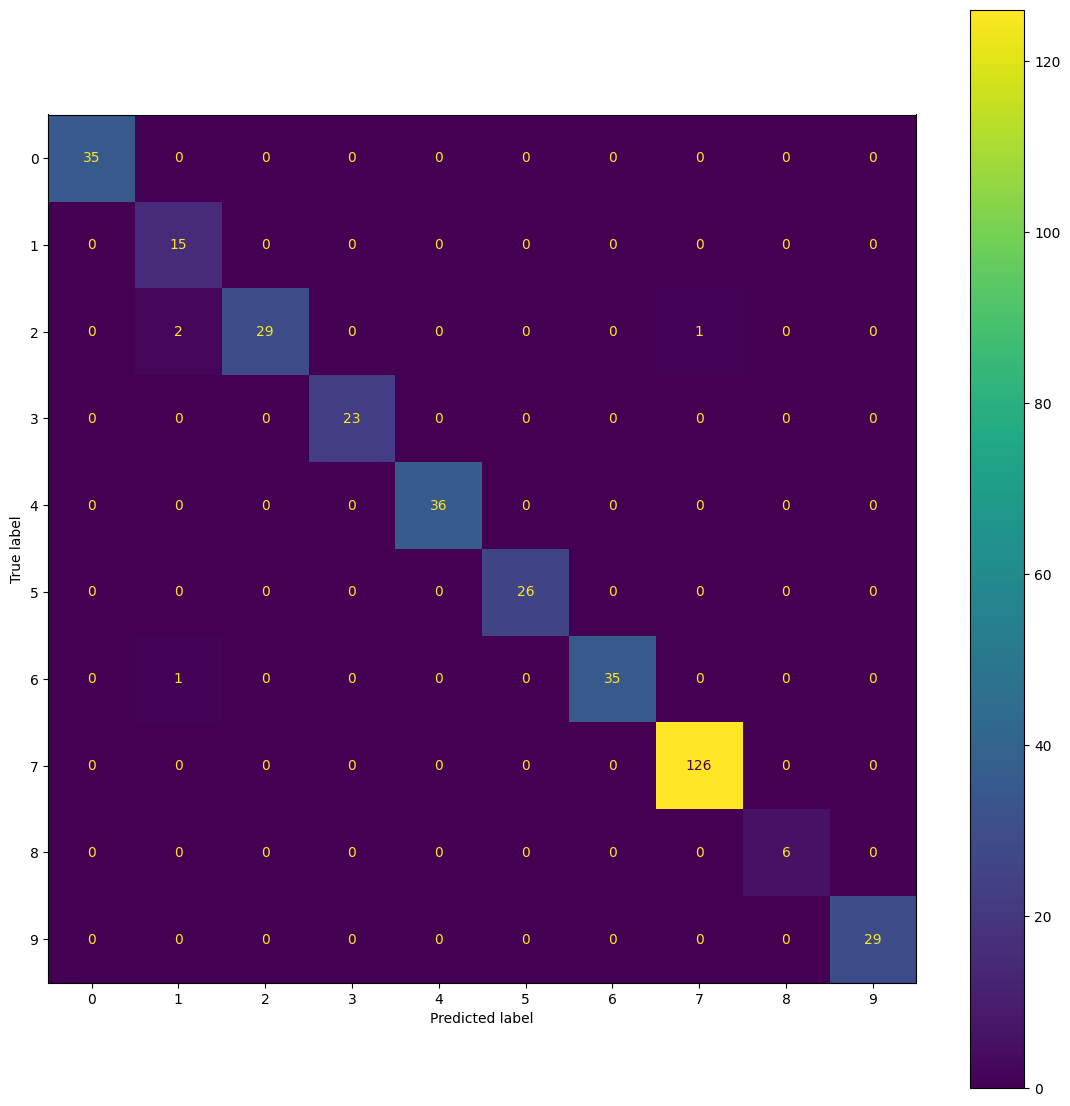

In [30]:
# Define the directory and the file path
output_dir = "resnet25epochs2"
output_file = "confusionmatrix2.png"
output_path = os.path.join(output_dir, output_file)

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the confusion matrix plot
cmp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
fig, ax = plt.subplots(figsize=(14, 14))
cmp.plot(ax=ax)
plt.savefig(output_path)

# Print performance metrics
print(f'Test Loss: {test_loss:4f}')
print(f'Test Acc: {test_acc:4f}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

**Plots and saves the training and validation loss across epochs to visualize model performance over time.**

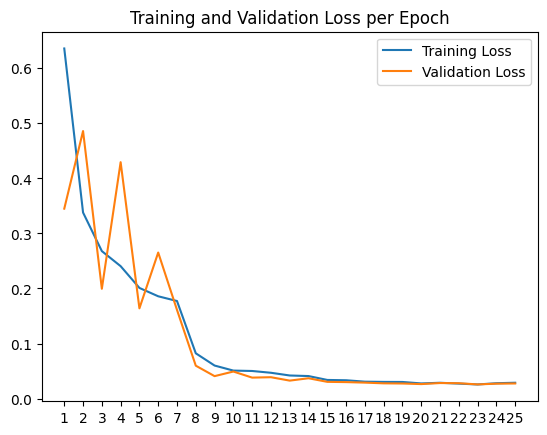

In [31]:
epochs = [i for i in range(1, num_epochs + 1)]
plt.plot(epochs, losses['train'], label="Training Loss")
plt.plot(epochs, losses['val'], label="Validation Loss")
plt.xticks(epochs)
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.savefig('resnet25epochs2/loss.png')

**Plots and saves the training and validation accuracy across epochs to visualize model performance over time.**

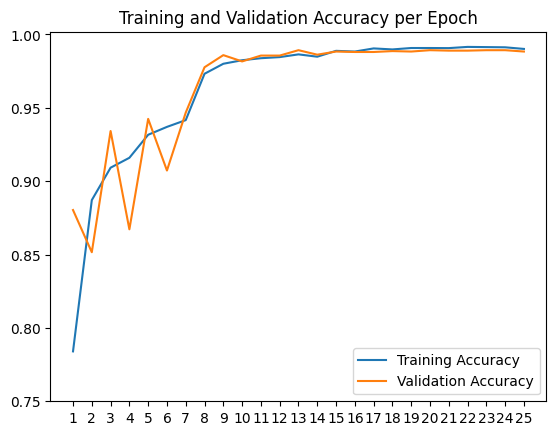

In [32]:
epochs = [i for i in range(1, num_epochs + 1)]
plt.plot(epochs, accs['train'], label="Training Accuracy")
plt.plot(epochs, accs['val'], label="Validation Accuracy")
plt.xticks(epochs)
plt.yticks(np.arange(0.75, 1.02, 0.05))
plt.title("Training and Validation Accuracy per Epoch")
plt.legend()
plt.savefig('resnet25epochs2/accuracy.png')


In [33]:
def imshow(inp):
    inp = np.swapaxes(inp, 0, 2)
    inp = np.swapaxes(inp, 0, 1)
    plt.imshow(np.array(inp), vmin=0, vmax=1)

In [34]:
def visualize_model(model, num_images=6):
    model.eval()
    image_count = 0
    fig = plt.figure(figsize=(12, 12))

    with torch.no_grad():
        for _, (inputs, labels) in enumerate(loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                image_count += 1
                ax = plt.subplot(num_images//2, 2, image_count)
                ax.axis('off')
                ax.set_title(f'predicted: {distinct_labels[preds[j]]}')
                imshow(inputs[j].cpu())

                if image_count == num_images:
                    fig.savefig('resnet25epochs2/predictions.png', format="png")
                    return

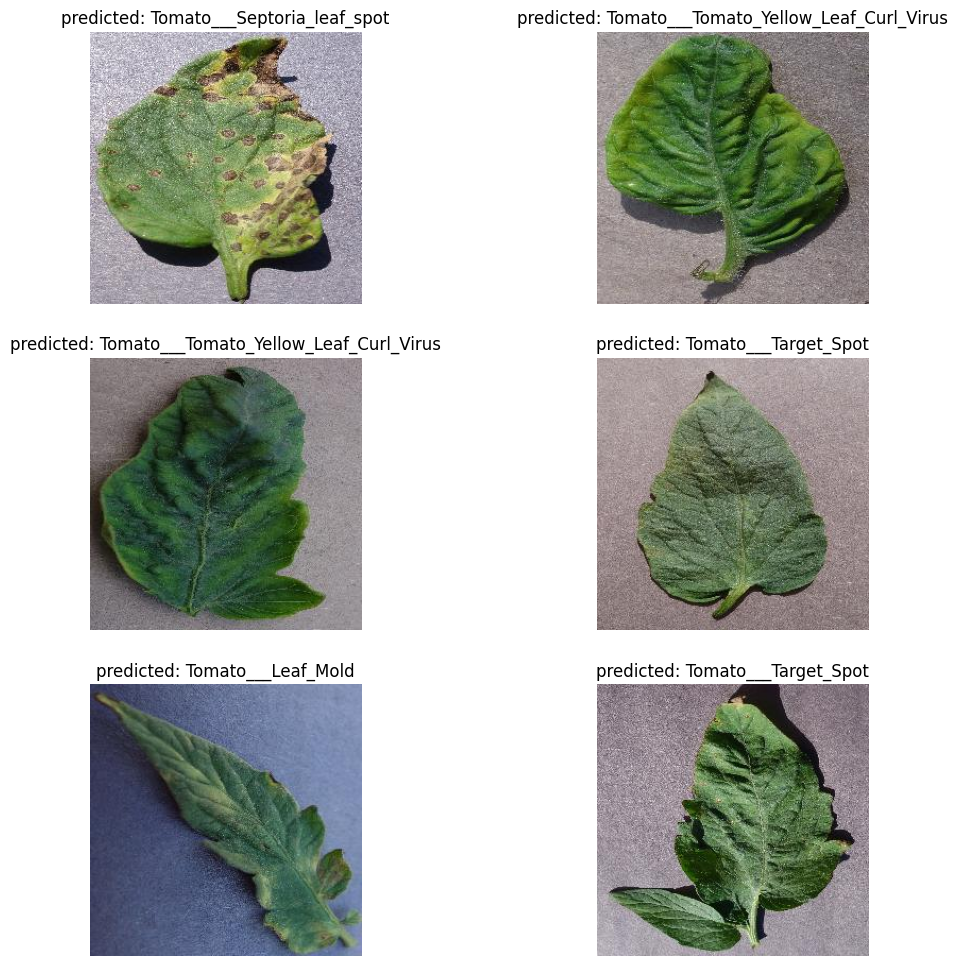

In [35]:
visualize_model(model)